In [81]:
import numpy as np
from collections import Counter

#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

from numpy.lib.stride_tricks import sliding_window_view as ws_split
from skimage.filters import threshold_otsu

from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, f1_score

from seaborn import heatmap
import numpy as np
import matplotlib.pyplot as plt

#import sys
#sys.path.append('/content/drive/MyDrive/TesisNotebooks')

from PQmodel import PQ
#from numba import jit

In [82]:
catalog=['Pure sinusoidal [0]', 'Sag[1]', 'Swell[2]','Interruption[3]','Transient/Impulse/Spike[4]',
         'Oscillatory transient [5]','Harmonics[6]','Harmonics with Sag[7]', 'Harmonics with Swell[8]',
         'Flicker[9]', 'Flicker with Sag[10]', 'Flicker with Swell[11]', 'Sag with Oscillatory transient[12]',
         'Swell with Oscillatory transient [13]', 'Sag with Harmonics [14]', 'Swell with Harmonics [15]', 'Notch [16]',
         'Harmonics with Sag with Flicker [17]', 'Harmonics with Swell with Flicker [18]',  'Sag with Harmonics with Flicker [19]',
         'Swell with Harmonics with Flicker [20]', 'Sag with Harmonics with Oscillatory transient [21]',
         'Swell with Harmonics with Oscillatory transient [22]', 'Harmonics with Sag with Oscillatory transient [23]',
         'Harmonics with Swell with Oscillatory transient [24]','Harmonics with Sag with Flicker with Oscillatory transient [25]',
         'Harmonics with Swell with Flicker with Oscillatory transient [26]', 'Sag with Harmonics with Flicker with Oscillatory transient [27]'
         'Swell with Harmonics with Flicker with Oscillatory transient [28]']

In [83]:
cicolosdist=10
Prueba = PQ(Cicles=cicolosdist,PeriodoDisturbio=cicolosdist,InicioDisturbio=0,FS=3841)

In [84]:
datos = Prueba.PQaleatorio(10)
datos.shape

(10, 29, 640)

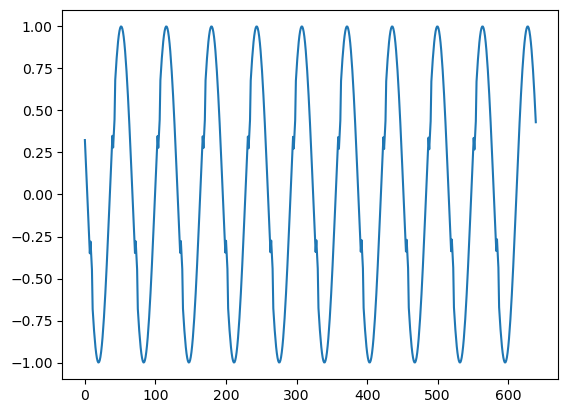

In [85]:
plt.plot(datos[1,16])
plt.show()

In [86]:
k=64#320
w=k
db=[]
dbl=[]
s = datos[0,4]
sample = (s-np.tile(s[:k],10))
th = np.abs(sample) > threshold_otsu(np.abs(sample))
labels=[]
for i in range(len(s)//w):
    c=Counter(th[i*w:i*w+w])
    ll=[c.get(True,0)!=0 for j in range(w)]
    labels+=ll
sd,sl= ws_split(s,window_shape=64),ws_split(labels,window_shape=64)

for iw in range(len(sd)):
    db.append(sd[iw])
    if True in sl[iw]:
                #print(sl[iw])
        dbl.append(4)
    else:
        dbl.append(0)

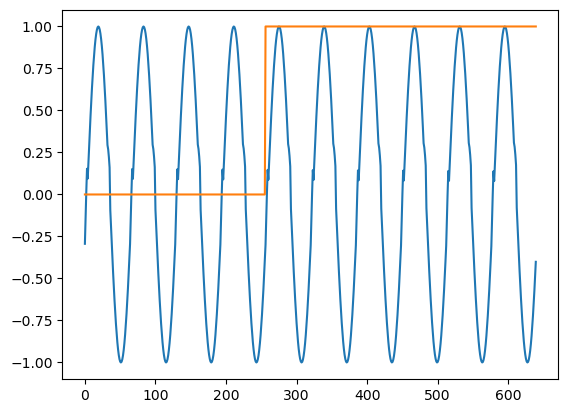

In [87]:
plt.plot(s)
plt.plot(labels)
plt.show()

In [88]:
def build_data(data,cs=16):
    Muestras,tSenal,LSenal=data.shape
    db,dbl=[],[]
    for j in range(Muestras):
        for k in range (tSenal):
            s = data[j,k]
            sd= ws_split(s,window_shape=cs)
            for iw in range(len(sd)):
                db.append(sd[iw])
                dbl.append(k)

    return np.array(db),np.array(dbl)

In [54]:
def build_dataClass(data,cs=16):
    Muestras,tSenal,LSenal=data.shape
    xt,yt1,yt2,yt3,yt4 = [],[],[],[],[]
    UFalla = 6  ##Denota un grupo de senales con una falla
    DFalla = 16 ##Denota el grupo de senales con dos fallas
    TFalla = 24 ##Denota el grupo de senales con tres fallas
    for j in range(Muestras):
        for k in range (tSenal):
            s = data[j,k]
            sd= ws_split(s,window_shape=cs)
            for iw in range(len(sd)):
                xt.append(sd[iw])
                if k <= UFalla or k==DFalla :
                    yt1.append(k)
                    yt2.append(0)
                    yt3.append(0)
                    yt4.append(0)
                elif k > UFalla and k < DFalla :
                    yt1.append(9)
                    yt2.append(k)
                    yt3.append(0)
                    yt4.append(0)
                elif k > DFalla  and k <= TFalla:
                    yt1.append(9)
                    yt2.append(0)
                    yt3.append(k)
                    yt4.append(0)
                elif k > TFalla :
                    yt1.append(9)
                    yt2.append(0)
                    yt3.append(0)
                    yt4.append(k)

    return np.array(xt),np.array(yt1),np.array(yt2),np.array(yt3),np.array(yt4)

In [89]:
dd,target1,target2,target3,target4=build_dataClass(datos,cs=128)

dd2,target=build_data(datos,cs=128)
print(np.bincount(target1))

[  5130   5130   5130   5130   5130   5130   5130      0      0 107730
      0      0      0      0      0      0   5130]


In [90]:
def cross_val2(model, X,y):

    skf=StratifiedKFold(n_splits=5, random_state=33, shuffle=True)
    yo,yp=[],[]
    i=1
    for ti,vi in skf.split(X, y):
        #print(vi.shape,y.shape)
        print(f"Fold: {i}")
        i+=1
        model.fit(X[ti],y[ti])
        yp+=list(model.predict(X[vi]))
        yo+=list(y[vi])
    return np.array(yp), np.array(yo)

In [91]:
print(dd.shape,target1.shape)

(148770, 128) (148770,)


In [146]:
def cross_val(model, X,y,y1,y2,y3):

    skf=StratifiedKFold(n_splits=5, random_state=33, shuffle=True)
    yo,yp,yo1,yp1,yo2,yp2,yo3,yp3=[],[],[],[],[],[],[],[]
    i=1

    for ti,vi in skf.split(X, y):
        print(f"Fold: {i}")
        i+=1
        model[0].fit(X[ti],y[ti])
        yp += list(model[0].predict(X[vi]))
        yo += list(y[vi])
    i=1
    for ti,vi in skf.split(X, y1):
       
        print(f"Fold: {i}")
        i+=1
        model[1].fit(X[ti],y1[ti])
        yp1 += list(model[1].predict(X[vi]))
        yo1 += list(y1[vi])
    i=1
    for ti,vi in skf.split(X, y2):
       
        print(f"Fold: {i}")
        i+=1
        model[2].fit(X[ti],y2[ti])
        yp2 += list(model[2].predict(X[vi]))
        yo2 += list(y2[vi])
    i=1
    for ti,vi in skf.split(X, y3):
        
        print(f"Fold: {i}")
        i+=1
        model[3].fit(X[ti],y3[ti])
        yp3 += list(model[3].predict(X[vi]))
        yo3 += list(y3[vi])


    return np.array(yp), np.array(yo),np.array(yp1), np.array(yo1),np.array(yp2), np.array(yo2),np.array(yp3), np.array(yo3)

In [142]:
model =[]
for v in range(5):
    model.append(KNeighborsClassifier())#=[KNeighborsClassifier(),KNeighborsClassifier(),KNeighborsClassifier(),KNeighborsClassifier()]


In [143]:
model[4].fit(dd,target)

KNeighborsClassifier()

In [147]:
yp,yo,yp1,yo1,yp2,yo2,yp3,yo3,=cross_val(model,dd,target1,target2,target3,target4)

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5


In [145]:
tt,tt1=cross_val2(model[0], dd2,target)

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5


In [97]:
def elimina_zeros(trgt):
    return np.array([k for k in np.bincount(trgt) if k>0])


In [127]:
cmt =confusion_matrix(tt,tt1) 
f1_score(tt,tt1,average='weighted')

0.9345835385039747

<Axes: >

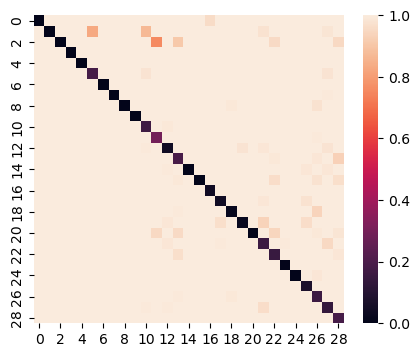

In [128]:
fig, ax = plt.subplots(figsize=(5,4))
heatmap(1-cmt/np.bincount(target), ax=ax)


In [148]:
cm = confusion_matrix(yo,yp)
cm1 = confusion_matrix(yo1,yp1)
cm2 = confusion_matrix(yo2,yp2)
cm3 = confusion_matrix(yo3,yp3)


In [149]:
totalcm=confusion_matrix(np.concatenate((yo,yo1,yo2,yo3)),np.concatenate((yp,yp1,yp2,yp3)))

In [150]:
kus = elimina_zeros(target1)
kus1 = elimina_zeros(target2)
kus2 = elimina_zeros(target3)
kus3 = elimina_zeros(target4)
print(kus,'\n',kus1,'\n',kus2,'\n',kus3)

[  5130   5130   5130   5130   5130   5130   5130 107730   5130] 
 [102600   5130   5130   5130   5130   5130   5130   5130   5130   5130] 
 [107730   5130   5130   5130   5130   5130   5130   5130   5130] 
 [128250   5130   5130   5130   5130]


In [151]:
f1_score(yo,yp,average='weighted')

0.9723928992661768

In [152]:
f1_score(yo1,yp1,average='weighted')

0.9627154199324315

In [153]:
f1_score(yo2,yp2,average='weighted')

0.9736589270191613

In [154]:
f1_score(yo3,yp3,average='weighted')

0.9767712793550283

<Axes: >

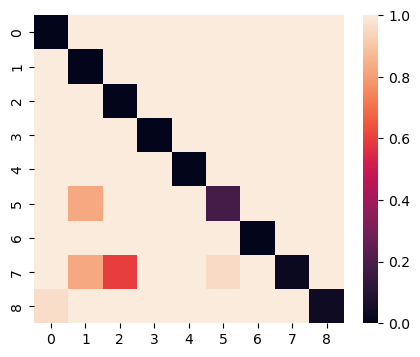

In [155]:
fig, ax = plt.subplots(figsize=(5,4))
heatmap(1-cm/kus, ax=ax)

<Axes: >

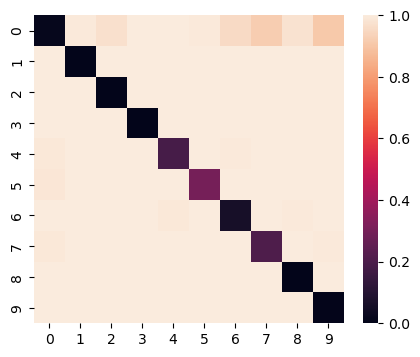

In [156]:
fig, ax = plt.subplots(figsize=(5,4))
heatmap(1-cm1/kus1, ax=ax)

<Axes: >

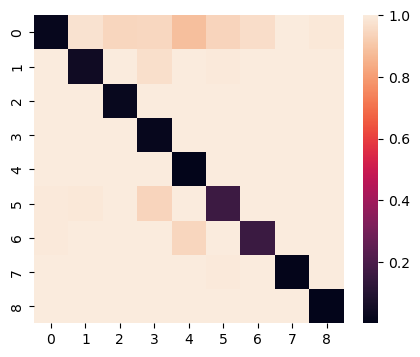

In [157]:
fig, ax = plt.subplots(figsize=(5,4))
heatmap(1-cm2/kus2, ax=ax)

<Axes: >

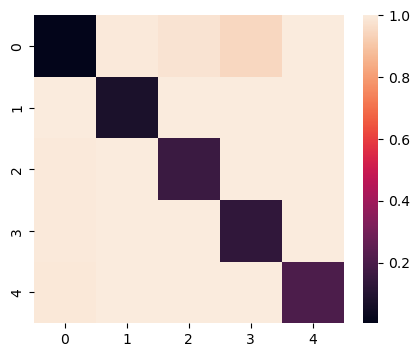

In [158]:
fig, ax = plt.subplots(figsize=(5,4))
heatmap(1-cm3/kus3, ax=ax)

In [159]:
m=1-cm/kus
print(m.shape)
m1=1-cm1/kus1
print(m1.shape)
m2=1-cm2/kus2
print(m2.shape)
m3=1-cm3/kus3
print(m3.shape)


(9, 9)
(10, 10)
(9, 9)
(5, 5)


In [160]:
total=np.ones((30,30))
total[0:9,0:9]=m
total[8:18,8:18]=m1
total[17:26,17:26]=m2
total[25:30,25:30]=m3

<Axes: >

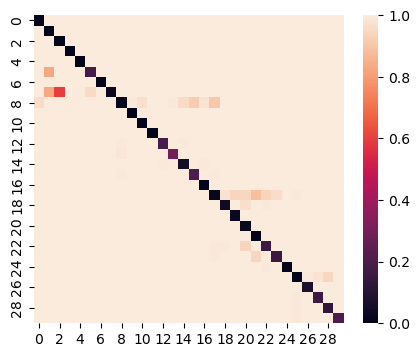

In [161]:
fig, ax = plt.subplots(figsize=(5,4))
heatmap(total, ax=ax)